# Basic test observation script from Benjamin: track, scan, drift
Measures total power on traget

In [22]:
%pylab inline
import os
import katdal
import katpoint
import scape
import string
import time

Populating the interactive namespace from numpy and matplotlib


## Approximate Tsys $\approx$ Tant
Using the noise models from EMSS calculations

In [23]:
# Boltzman constant
k = 1.38e-23
# L-band receptors
receptor_serial={
'm062':{'band':'l', 'serial':4001},
'm063':{'band':'l', 'serial':4002},
'm031':{'band':'l', 'serial':4005},
'm034':{'band':'l', 'serial':4010},
'm024':{'band':'l', 'serial':4},
'm025':{'band':'l', 'serial':4003}}
# Name of directory containing noise diode model files
nd_models ='/var/kat/katconfig/user/noise-diode-models/mkat'
def modelTcal(noisefile):
    ##Read data from file
    fin = open(noisefile, 'r')
    # Read and ignore header line
    fin.readline()
    fin.readline()
    # Read model data [freq Hz, Te K]
    nd_freqs = []
    nd_temps = []
    for line in fin.readlines():
        try:
            noisemodel= numpy.array(line.strip().split(','), dtype=float)
        except: print line.strip()
        nd_freqs.append(noisemodel[0])
        nd_temps.append(noisemodel[1])
    fin.close()
    nd_freqs = numpy.array(nd_freqs)
    nd_temps = numpy.array(nd_temps)
    return [nd_freqs, nd_temps]

    [nd_freqs, nd_temps] = modelTcal(os.path.join(nd_models,nd_file))
    Tsys = numpy.mean(nd_temps)

In [24]:
#filename ='/var/kat/archive/data/MeerKATAR1/telescope_products/2016/02/16/1455601380.h5'

#2016-03-30 16:03:01 (Pic A)
filename ='/var/kat/archive/data/MeerKATAR1/telescope_products/2016/03/30/1459346580.h5'

#2016-03-30 16:20:27 (PKS 0023-263)
filename='/var/kat/archive/data/MeerKATAR1/telescope_products/2016/03/30/1459347625.h5'

#2016-03-30 16:35:52 (GPS BIIR-2  (PRN 13))
filename='/var/kat/archive/data/MeerKATAR1/telescope_products/2016/03/30/1459348551.h5'

#2016-03-30 19:20:43 (Jupiter)
filename='/var/kat/archive/data/MeerKATAR1/telescope_products/2016/03/30/1459358442.h5'

#2016-03-30 19:44:00 (Jupiter)
filename='/var/kat/archive/data/MeerKATAR1/telescope_products/2016/03/30/1459359839.h5'

#2016-04-05 07:46:42 (PKS 1610-60)
filename='/var/kat/archive/data/MeerKATAR1/telescope_products/2016/04/05/1459835201.h5'

#2016-04-05 08:06:07 (PKS 0023-263)
filename='/var/kat/archive/data/MeerKATAR1/telescope_products/2016/04/05/1459836366.h5'

#2016-04-05 08:33:29 (GPS BIIR-3 (PRN 11))
filename='/var/kat/archive/data/MeerKATAR1/telescope_products/2016/04/05/1459838008.h5'

#2016-04-05 08:49:31 (Moon)
filename='/var/kat/archive/data/MeerKATAR1/telescope_products/2016/04/05/1459838971.h5'

#2016-04-05 09:48:49 (GPS BIIRM-1 (PRN 17))
filename='/var/kat/archive/data/MeerKATAR1/telescope_products/2016/04/05/1459842528.h5'

try:
    h5 = katdal.open(filename, quicklook=True)
except Exception as err_msg: raise SystemExit('An error as occured:\n%s' % err_msg)
passband = h5.channel_freqs
ants = h5.ants

observation_power_measurements={}
observation_data={}
for ant in ants:
    observation_power_measurements[ant.name]={}
    observation_data[ant.name]={}
    for pol in ['H','V']:
        observation_power_measurements[ant.name][pol]={'track':{'mean':[],'std':[]},
                                                       'scan':{'max':[],'min':[]},
                                                       'drift':{'max':[],'min':[]}}

        # approximate Tsys using Tant values from model files
        nd_file='rx.l.%d.%s.csv'%(receptor_serial[ant.name]['serial'],string.lower(pol))
        [nd_freqs, nd_temps] = modelTcal(os.path.join(nd_models,nd_file))
        Tsys = numpy.mean(nd_temps)  
        Ssys = 10.*numpy.log10(k*Tsys) + 30 # dBm/Hz
#        print "Expected power spectral density of the system noise floor %.2d [dBm/Hz]" % Ssys
        observation_data[ant.name][pol]={'Ssys':Ssys,
                                         'track':{'time':{},'series':{},'label':{}},
                                         'scan':{'time':{},'series':{},'label':{}},
                                         'drift':{'time':{},'series':{},'label':{}}}

##Tracking target for 30 seconds
Observation will do a track at the beginning and a track at the end

Tracking target: GPS BIIRM-1 (PRN 17)
Observation data for antenna m062, polarisation H
Observation data for antenna m062, polarisation V
Observation data for antenna m034, polarisation H
Observation data for antenna m034, polarisation V
Observation data for antenna m031, polarisation H
Observation data for antenna m031, polarisation V


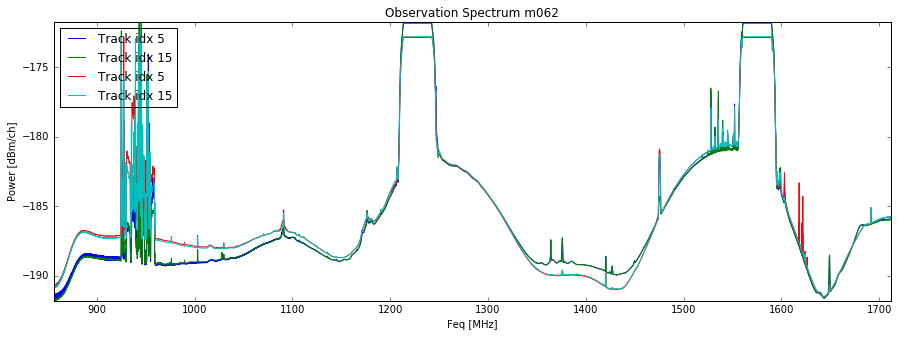

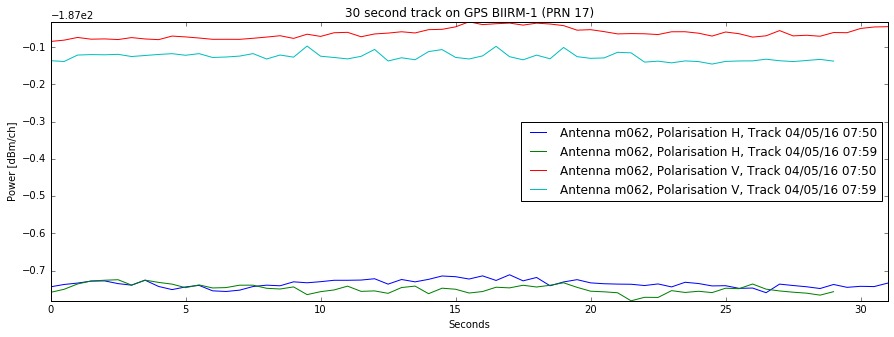

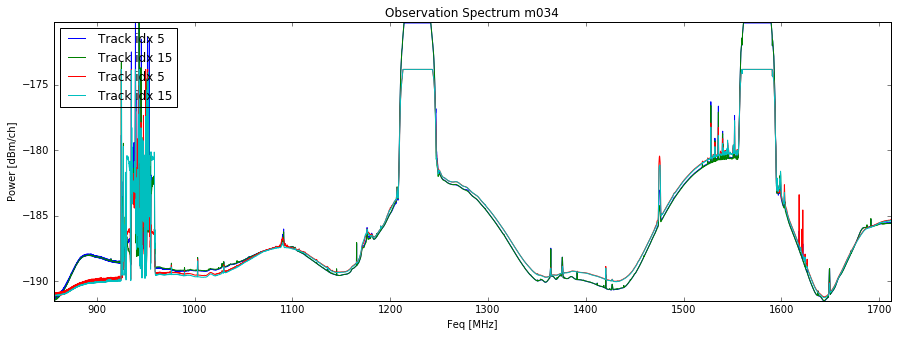

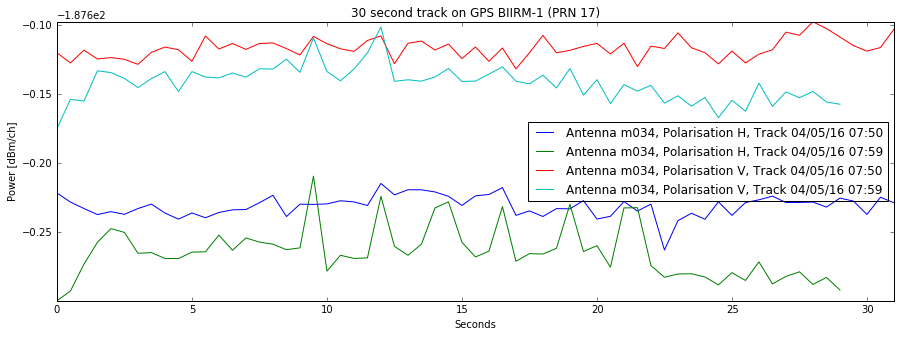

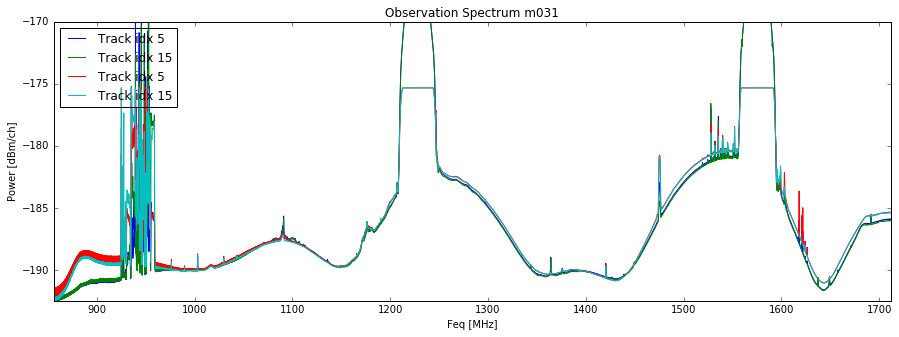

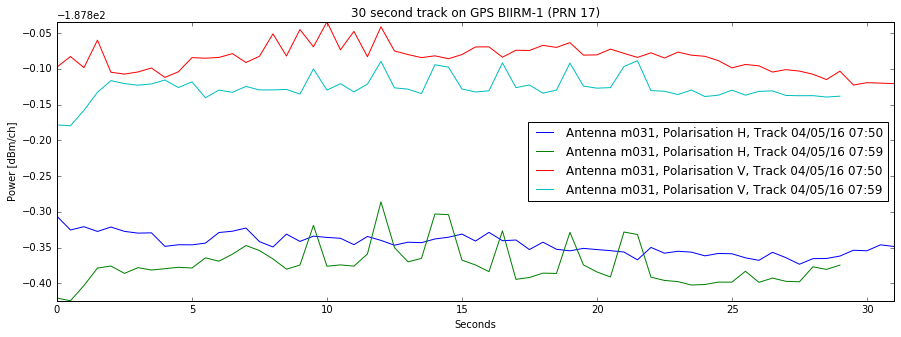

In [25]:
h5.select()
target = h5.catalogue.targets[0].name
print "Tracking target: %s" % target

for ant_idx in range(len(ants)):
    ant = ants[ant_idx]
    for pol in ['H','V']:
        print 'Observation data for antenna %s, polarisation %s' % (ant.name,pol)
    
        h5.select(reset='T')
        h5.select(ants=ant.name, pol=pol, corrprods='auto',scans='track',compscans='track')
        scan_indices = h5.scan_indices

        for idx in range(len(scan_indices)):
            h5.select(scans=scan_indices[idx])
            key='Antennas/%s/nd_coupler'%ant.name
            tracksecs= h5.timestamps-h5.timestamps[0]
            data = numpy.abs(h5.vis[:])[~h5.sensor[key]] 

            # power calibration scale factor
            buff_chan = len(passband)/10
            bp_floor =  (10*numpy.log10(numpy.median(numpy.abs(data), axis=0)))[buff_chan:-buff_chan].mean()
            delta_P = bp_floor - observation_data[ant.name][pol]['Ssys']
            observation_data[ant.name][pol]['track']['time'][idx]= tracksecs
            observation_data[ant.name][pol]['track']['series'][idx]= 10*numpy.log10(numpy.median(numpy.abs(data), axis=1))-delta_P
            observation_data[ant.name][pol]['track']['label'][idx]= 'Antenna %s, Polarisation %s, Track %s'%(ant.name, pol, time.strftime("%D %H:%M", time.localtime(h5.timestamps[0])))
            observation_power_measurements[ant.name][pol]['track']['mean'].append((10*numpy.log10(numpy.median(numpy.abs(data), axis=1))-delta_P).mean())
            observation_power_measurements[ant.name][pol]['track']['std'].append((10*numpy.log10(numpy.median(numpy.abs(data), axis=1))-delta_P).std())

            plt.figure(2*ant_idx,figsize = (15,5))
            plt.plot(passband/1e6, 10*numpy.log10(numpy.median(numpy.abs(data), axis=0))-delta_P, label='Track idx %d'%scan_indices[idx])       
            plt.axis('tight')
            plt.xlabel('Feq [MHz]')
            plt.ylabel('Power [dBm/ch]')
            plt.title('Observation Spectrum %s'%ant.name)
            plt.legend(loc=0)
            plt.figure(2*ant_idx+1,figsize = (15,5))
            plt.plot(observation_data[ant.name][pol]['track']['time'][idx],
                     observation_data[ant.name][pol]['track']['series'][idx],
                     label=observation_data[ant.name][pol]['track']['label'][idx])
            plt.axis('tight')
            plt.xlabel('Seconds')
            plt.ylabel('Power [dBm/ch]')
            plt.title('30 second track on %s'%target)
            plt.legend(loc=0)


## Raster scan across target

Raster scan target: GPS BIIRM-1 (PRN 17)
Observation data for antenna m062
Observation data for antenna m062, polarisation H
Observation data for antenna m062, polarisation V
Observation data for antenna m034
Observation data for antenna m034, polarisation H
Observation data for antenna m034, polarisation V
Observation data for antenna m031
Observation data for antenna m031, polarisation H
Observation data for antenna m031, polarisation V


/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:27: VisibleDeprecationWarning: boolean index did not match indexed array along dimension 0; dimension is 40 but corresponding boolean dimension is 39
/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:28: VisibleDeprecationWarning: boolean index did not match indexed array along dimension 0; dimension is 40 but corresponding boolean dimension is 39
/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:30: VisibleDeprecationWarning: boolean index did not match indexed array along dimension 0; dimension is 40 but corresponding boolean dimension is 39
/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:31: VisibleDeprecationWarning: boolean index did not match indexed array along dimension 0; dimension is 40 but corresponding boolean dimension is 39


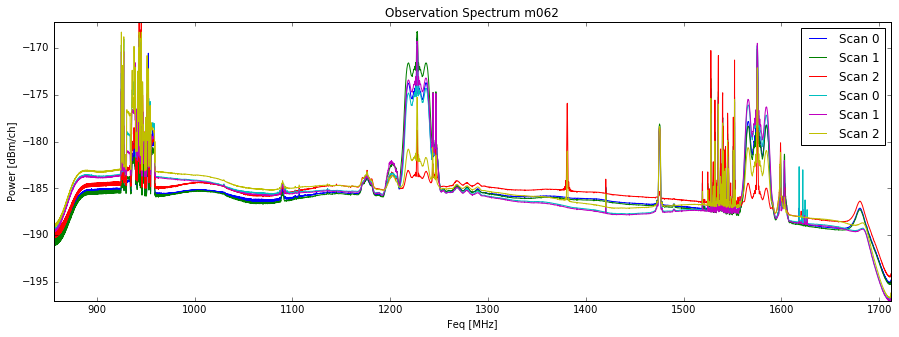

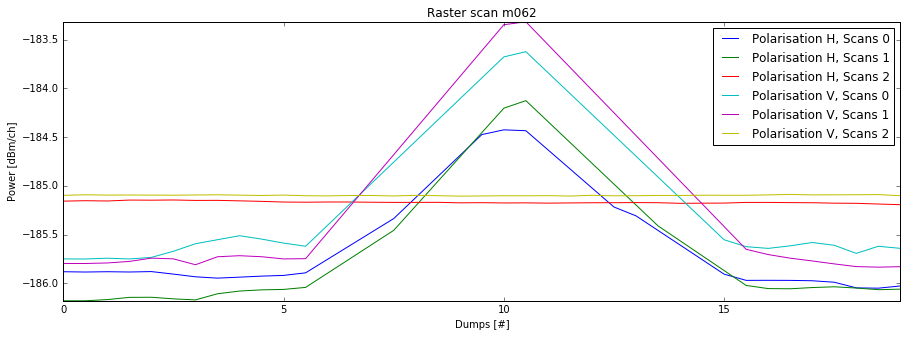

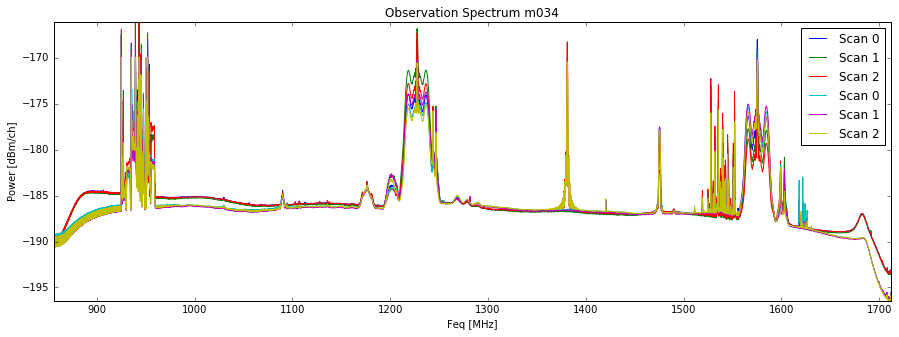

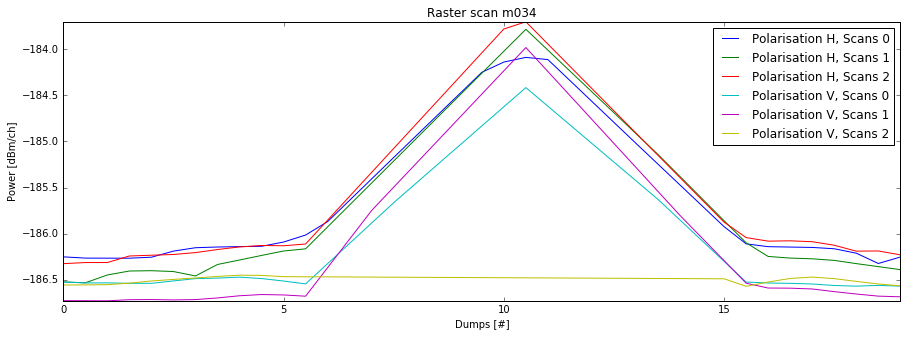

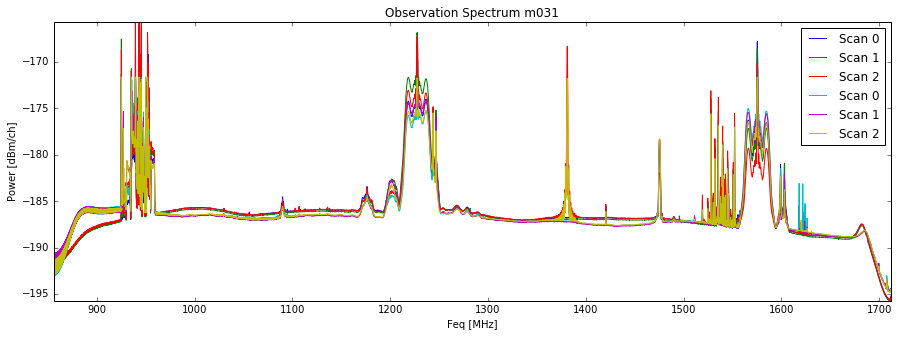

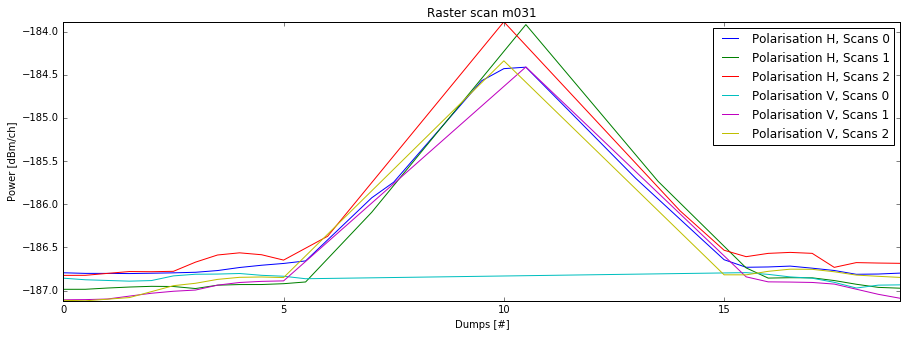

In [26]:
h5.select()
target = h5.catalogue.targets[0].name
print "Raster scan target: %s" % target

for ant_idx in range(len(ants)):
    ant = ants[ant_idx]
    print 'Observation data for antenna %s' % ant.name
        
    for pol in ['H','V']:
        print 'Observation data for antenna %s, polarisation %s' % (ant.name,pol)
    
        h5.select(reset='T')
        h5.select(ants=ant.name, pol=pol, corrprods='auto',scans='scan')
        scan_indices = h5.scan_indices

        for idx in range(len(scan_indices)):
            h5.select(scans=scan_indices[idx])
            key='Antennas/%s/nd_coupler'%ant.name
            tracksecs= h5.timestamps-h5.timestamps[0]
            data = numpy.abs(h5.vis[:])[~h5.sensor[key]] 

            # power calibration scale factor
            buff_chan = len(passband)/10
            bp_floor =  (10*numpy.log10(numpy.median(numpy.abs(data), axis=0)))[buff_chan:-buff_chan].mean()
            delta_P = bp_floor - observation_data[ant.name][pol]['Ssys']
            boolidx= numpy.abs(numpy.diff(numpy.median(numpy.abs(data), axis=1).flatten()))>10.
            observation_data[ant.name][pol]['scan']['time'][idx]= tracksecs[~boolidx]
            observation_data[ant.name][pol]['scan']['series'][idx]= 10*numpy.log10(numpy.median(numpy.abs(data), axis=1))[~boolidx]-delta_P
            observation_data[ant.name][pol]['scan']['label'][idx]= 'Polarisation %s, Scans %d'%(pol,idx)
            observation_power_measurements[ant.name][pol]['scan']['max'].append((10*numpy.log10(numpy.median(numpy.abs(data), axis=1))[~boolidx]-delta_P).max())
            observation_power_measurements[ant.name][pol]['scan']['min'].append((10*numpy.log10(numpy.median(numpy.abs(data), axis=1))[~boolidx]-delta_P).min())

            plt.figure(2*ant_idx,figsize = (15,5))
            plt.plot(passband/1e6, 10*numpy.log10(numpy.median(numpy.abs(data), axis=0))-delta_P, label='Scan %d'%idx)       
            plt.axis('tight')
            plt.xlabel('Feq [MHz]')
            plt.ylabel('Power [dBm/ch]')
            plt.title('Observation Spectrum %s'%ant.name)
            plt.legend(loc=0)
            plt.figure(2*ant_idx+1,figsize = (15,5))
            plt.plot(observation_data[ant.name][pol]['scan']['time'][idx],
                     observation_data[ant.name][pol]['scan']['series'][idx],
                     label=observation_data[ant.name][pol]['scan']['label'][idx])
            plt.axis('tight')
            plt.xlabel('Dumps [#]')
            plt.ylabel('Power [dBm/ch]')
            plt.title('Raster scan %s'%ant.name)
            plt.subplots_adjust(wspace=None, hspace=None)
            plt.legend(loc=0)

## Drift scan of target

/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:25: VisibleDeprecationWarning: boolean index did not match indexed array along dimension 0; dimension is 651 but corresponding boolean dimension is 627
/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:26: VisibleDeprecationWarning: boolean index did not match indexed array along dimension 0; dimension is 628 but corresponding boolean dimension is 627
/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:28: VisibleDeprecationWarning: boolean index did not match indexed array along dimension 0; dimension is 628 but corresponding boolean dimension is 627
/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:29: VisibleDeprecationWarning: boolean index did not match indexed array along dimension 0; dimension is 628 but corresponding boolean dimension is 627


Drift scan target: GPS BIIRM-1 (PRN 17)
Observation data for antenna m062, polarisation H
Observation data for antenna m062, polarisation V
Observation data for antenna m034, polarisation H

/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:25: VisibleDeprecationWarning: boolean index did not match indexed array along dimension 0; dimension is 651 but corresponding boolean dimension is 625
/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:26: VisibleDeprecationWarning: boolean index did not match indexed array along dimension 0; dimension is 626 but corresponding boolean dimension is 625
/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:28: VisibleDeprecationWarning: boolean index did not match indexed array along dimension 0; dimension is 626 but corresponding boolean dimension is 625
/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:29: VisibleDeprecationWarning: boolean index did not match indexed array along dimension 0; dimension is 626 but corresponding boolean dimension is 625



Observation data for antenna m034, polarisation V
Observation data for antenna m031, polarisation H

/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:25: VisibleDeprecationWarning: boolean index did not match indexed array along dimension 0; dimension is 651 but corresponding boolean dimension is 629
/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:26: VisibleDeprecationWarning: boolean index did not match indexed array along dimension 0; dimension is 630 but corresponding boolean dimension is 629
/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:28: VisibleDeprecationWarning: boolean index did not match indexed array along dimension 0; dimension is 630 but corresponding boolean dimension is 629
/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:29: VisibleDeprecationWarning: boolean index did not match indexed array along dimension 0; dimension is 630 but corresponding boolean dimension is 629



Observation data for antenna m031, polarisation V


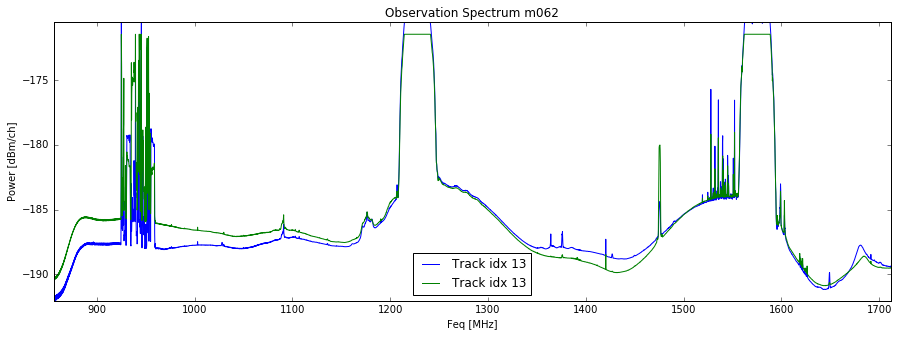

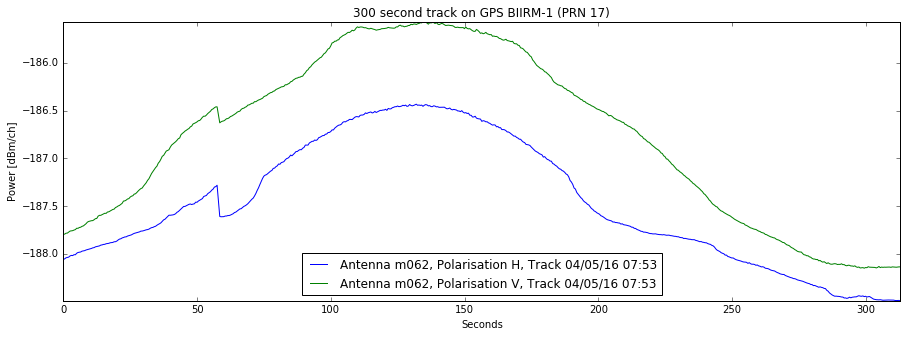

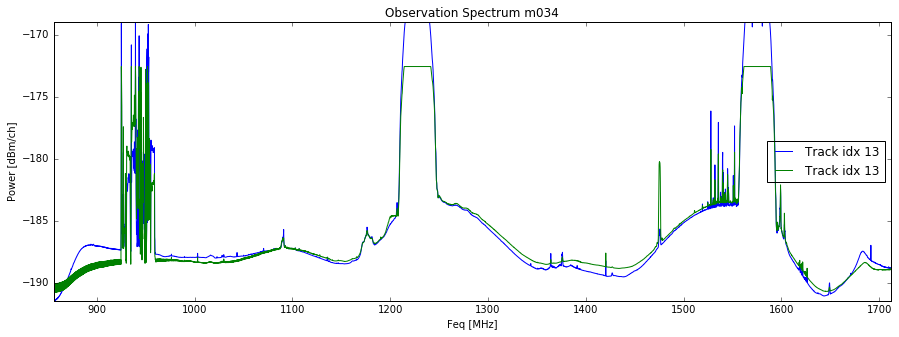

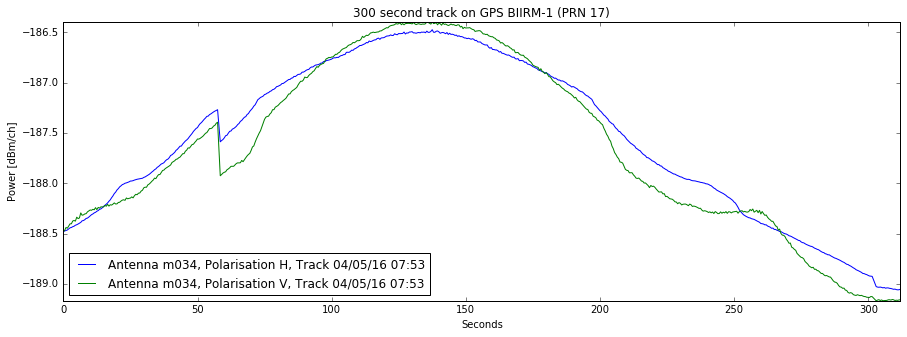

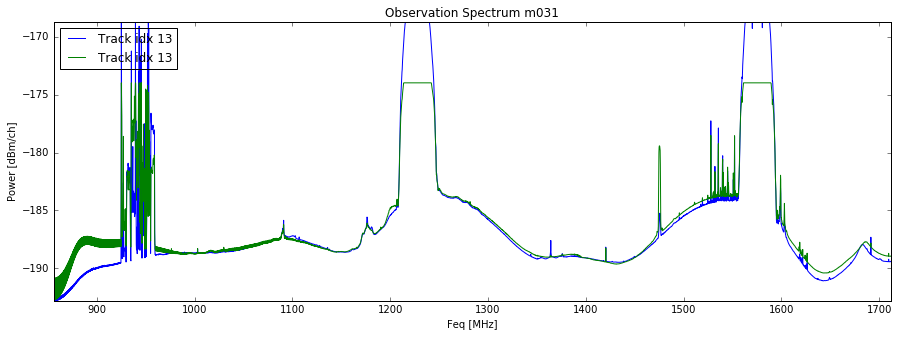

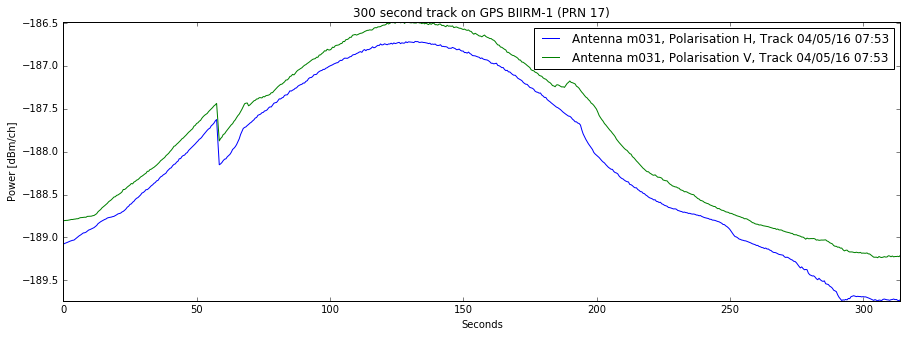

In [27]:
h5.select()
target = h5.catalogue.targets[0].name
print "Drift scan target: %s" % target
#print h5.catalogue.targets[1].name
for ant_idx in range(len(ants)):
    ant = ants[ant_idx]
    for pol in ['H','V']:
        print 'Observation data for antenna %s, polarisation %s' % (ant.name,pol)
    
        h5.select(reset='T')
        h5.select(ants=ant.name, pol=pol, corrprods='auto',scans='track',compscans='drift')
        scan_indices = h5.scan_indices

        for idx in range(len(scan_indices)):
            h5.select(scans=scan_indices[idx])
            key='Antennas/%s/nd_coupler'%ant.name
            tracksecs= h5.timestamps-h5.timestamps[0]
            data = numpy.abs(h5.vis[:])[~h5.sensor[key]] 

            # power calibration scale factor
            buff_chan = len(passband)/10
            bp_floor =  (10*numpy.log10(numpy.median(numpy.abs(data), axis=0)))[buff_chan:-buff_chan].mean()
            delta_P = bp_floor - observation_data[ant.name][pol]['Ssys']
            boolidx= numpy.abs(numpy.diff(numpy.median(numpy.abs(data), axis=1).flatten()))>10.
            observation_data[ant.name][pol]['drift']['time'][idx]= tracksecs[~boolidx]
            observation_data[ant.name][pol]['drift']['series'][idx]= 10*numpy.log10(numpy.median(numpy.abs(data), axis=1))[~boolidx]-delta_P
            observation_data[ant.name][pol]['drift']['label'][idx]= 'Antenna %s, Polarisation %s, Track %s'%(ant.name, pol, time.strftime("%D %H:%M", time.localtime(h5.timestamps[0])))
            observation_power_measurements[ant.name][pol]['drift']['max'].append((10*numpy.log10(numpy.median(numpy.abs(data), axis=1))[~boolidx]-delta_P).max())
            observation_power_measurements[ant.name][pol]['drift']['min'].append((10*numpy.log10(numpy.median(numpy.abs(data), axis=1))[~boolidx]-delta_P).min())

            plt.figure(2*ant_idx,figsize = (15,5))
            plt.plot(passband/1e6, 10*numpy.log10(numpy.median(numpy.abs(data), axis=0))-delta_P, label='Track idx %d'%scan_indices[idx])       
            plt.axis('tight')
            plt.xlabel('Feq [MHz]')
            plt.ylabel('Power [dBm/ch]')
            plt.title('Observation Spectrum %s'%ant.name)
            plt.legend(loc=0)
            plt.figure(2*ant_idx+1,figsize = (15,5))
            plt.plot(observation_data[ant.name][pol]['drift']['time'][idx],
                     observation_data[ant.name][pol]['drift']['series'][idx],
                     label=observation_data[ant.name][pol]['drift']['label'][idx])
            plt.axis('tight')
            plt.xlabel('Seconds')
            plt.ylabel('Power [dBm/ch]')
            plt.title('300 second track on %s'%target)
            plt.legend(loc=0)

## Generate Report

In [28]:
from matplotlib.backends.backend_pdf import PdfPages
h5.select()
target = h5.catalogue.targets[0].name
for ant in observation_power_measurements.keys():
    for pol in observation_data[ant].keys():
        outfilebase = '%s_%s_%s_3_scan_report' % (h5.experiment_id,ant,pol)
        
        # Generate output report
        with PdfPages(outfilebase+'.pdf') as pdf:        
            pagetext  = "\n3 Scan Observation"
            pagetext += "\n\nDescription: %s\nName: %s\nExperiment ID: %s" %(h5.description, h5.name, h5.experiment_id)
            pagetext  = pagetext + "\n"
            pagetext += "\n\nTest Setup: 2 Tracks on source, 5 scan Raster Scan across source, Drift scan of source"
            pagetext += "\n\nTarget: %s"%h5.catalogue.targets[0].name
            pagetext += "\n\nAntenna %s, Polarisation %s" % (ant,pol)
            pagetext += "\n------------"
            for idx in range(len(observation_power_measurements[ant][pol]['track']['mean'])):
                pagetext += '\nTrack %.3f [dBm/Hz] +- %.3f [dB]' % (observation_power_measurements[ant][pol]['track']['mean'][idx],observation_power_measurements[ant][pol]['track']['std'][idx])
            pagetext += '\nRaster Scan Max %.3f [dBm/Hz]'%numpy.max(observation_power_measurements[ant][pol]['scan']['max'])
            pagetext += '\nDrift Scan Max %.3f [dBm/Hz]'%numpy.max(observation_power_measurements[ant][pol]['drift']['max'])
            pwd_diff=abs(numpy.max(observation_power_measurements[ant][pol]['scan']['max'])-numpy.max(observation_power_measurements[ant][pol]['drift']['max']))
    #        print 'Difference between scan and drift', pwd_diff

            pwds = observation_power_measurements[ant][pol]['track']['mean']
            pwds.append(numpy.max(observation_power_measurements[ant][pol]['scan']['max']))
            pwds.append(numpy.max(observation_power_measurements[ant][pol]['drift']['max']))
            pwd_measured= numpy.max(pwds)-numpy.min(pwds)        
            pwd_range=max(numpy.array(observation_power_measurements[ant][pol]['scan']['max'])-numpy.array(observation_power_measurements[ant][pol]['scan']['min']))
            pwd_limit= pwd_range/2. + numpy.max(observation_power_measurements[ant][pol]['track']['std'])

            if abs(pwd_measured-pwd_limit) < 0.1:
                pagetext += '\nAll 3 on target at some point during observation'
            else:
                pagetext += '\nPointing may be off'
            pagetext = pagetext + "\n"

            plt.figure(None,figsize = (16,8))
            plt.axes(frame_on=False)
            plt.xticks([])
            plt.yticks([])
            plt.title("AR1 Report %s"%outfilebase ,fontsize=14, fontweight="bold")
            plt.text(0,0,pagetext,fontsize=12)
            pdf.savefig()
            plt.close()            


#            print "Tracking target: %s" % target
            plt.figure(figsize = (15,5))
            for idx in observation_data[ant][pol]['track']['time'].keys():
                plt.plot(observation_data[ant][pol]['track']['time'][idx],
                         observation_data[ant][pol]['track']['series'][idx],
                         label=observation_data[ant][pol]['track']['label'][idx])
                plt.axis('tight')
                plt.xlabel('Seconds')
                plt.ylabel('Power [dBm/ch]')
                plt.title('30 second track on %s'%target)
                plt.legend(loc=0)
            pdf.savefig()
            plt.close()


#            print "Raster scan target: %s" % target
            plt.figure(figsize = (15,5))
            for idx in observation_data[ant][pol]['scan']['time'].keys():
                plt.plot(observation_data[ant][pol]['scan']['time'][idx],
                         observation_data[ant][pol]['scan']['series'][idx],
                         label=observation_data[ant][pol]['scan']['label'][idx])
                plt.axis('tight')
                plt.xlabel('Dumps [#]')
                plt.ylabel('Power [dBm/ch]')
                plt.title('Raster scan %s'%ant)
                plt.legend(loc=0)
            pdf.savefig()
            plt.close()


#            print h5.catalogue.targets[1].name
            plt.figure(figsize = (15,5))
            for idx in range(len(scan_indices)):
                plt.plot(observation_data[ant][pol]['drift']['time'][idx],
                         observation_data[ant][pol]['drift']['series'][idx],
                         label=observation_data[ant][pol]['drift']['label'][idx])
                plt.axis('tight')
                plt.xlabel('Seconds')
                plt.ylabel('Power [dBm/ch]')
                plt.title('300 second drift scan using %s'%target)
                plt.legend(loc=0)
            pdf.savefig()
            plt.close()

            d = pdf.infodict()
            import datetime
            d['Title'] = h5.description
            d['Author'] = 'AR1'
            d['Subject'] = 'AR1 Pointing Observation'
            d['CreationDate'] = datetime.datetime(2016, 3, 30)
            d['ModDate'] = datetime.datetime.today()